# Marvel Heroes Classifier
### Link to web app: [https://serene-retreat-78507.herokuapp.com/](https://serene-retreat-78507.herokuapp.com/) **NOTE: This takes a long time to load, give it a couple minutes, refresh, and it will pop up**

---


Using `fastai`, this project attempts to create a classifier for Marvel heroes, with the intent of classifying which hero is in a picture.

## Create a Dataset
I'm using a fork of the `google-images-download` package in python to create our dataset of Marvel hero images. The fork is necessary for Colab compatibility issues.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install git+https://github.com/Joeclinton1/google-images-download.git

  Cloning https://github.com/Joeclinton1/google-images-download.git to /tmp/pip-req-build-cw1c__9r
  Running command git clone -q https://github.com/Joeclinton1/google-images-download.git /tmp/pip-req-build-cw1c__9r
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=15833 sha256=b1ee97176ad894fe5e1eeca11dc1b14995b4085183c88bba6e6bce266a5c4af8
  Stored in directory: /tmp/pip-ephem-wheel-cache-mag1z8al/wheels/1a/36/c9/53bd827bc241b69fe47b90731625459627f82694ecd8a88273
Successfully built google-images-download


In [ ]:
from google_images_download import google_images_download
response = google_images_download.googleimagesdownload() 

In [ ]:
# List of heroes to classify
queries = [
           'Spider-Man',
           'Captain America',
           'Iron Man',
           'The Hulk',
           'Thor',
           'Black Widow',
]

In [ ]:
# Downloads 100 images of comic covers for each hero and puts each in a folder images/<hero>
%%capture
!rm -r images
for query in queries:
    arguments = {
        "keywords": f'{query}',
        "limit": 100,
        "print_urls": False,
        "output_directory": "images",
        "image_directory": query,
    }

    try:
        response.download(arguments)
    except FileNotFoundError as e:
        print(e)

## Classification
Now that we have our dataset of comic book heroes, we will attempt to classify them with `fastai`

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 25kB/s 
     |████████████████████████████████| 4.0MB 37.7MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
import numpy as np
from fastai.vision import (
    ImageDataBunch, 
    Path, 
    get_transforms,
    imagenet_stats,
    cnn_learner,
    models,
    ClassificationInterpretation,
    verify_images,
    ImageList
)
from fastai.metrics import error_rate

In [ ]:
path = Path('images')

In [ ]:
path.ls()

[PosixPath('images/Spider-Man'),
 PosixPath('images/The Hulk'),
 PosixPath('images/Captain America'),
 PosixPath('images/Iron Man'),
 PosixPath('images/Thor'),
 PosixPath('images/Black Widow')]

In [ ]:
classes = queries

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

Spider-Man


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Captain America


cannot identify image file <_io.BufferedReader name='images/Captain America/75.3qlzyundrkwwokewzrxeif4heuc.jpg'>
Iron Man


The Hulk


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Thor


cannot identify image file <_io.BufferedReader name='images/Thor/90.chris%20hemsworth%20thor%20ragnarok.jpg'>
Black Widow


In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes

['Black Widow',
 'Captain America',
 'Iron Man',
 'Spider-Man',
 'The Hulk',
 'Thor']

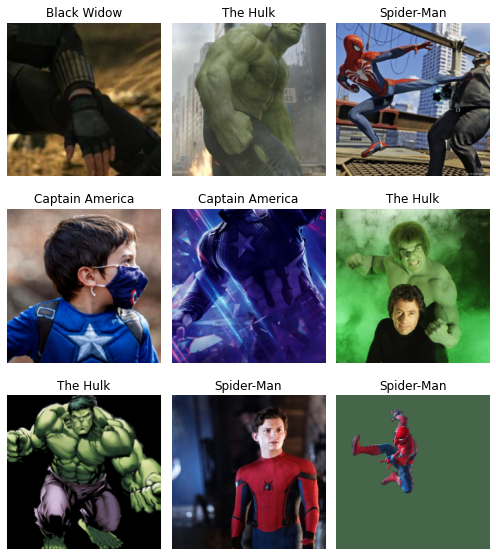

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Black Widow',
  'Captain America',
  'Iron Man',
  'Spider-Man',
  'The Hulk',
  'Thor'],
 6,
 445,
 111)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.035253,1.005318,0.342342,00:09
1,1.348823,0.541018,0.189189,00:07
2,0.990244,0.404541,0.126126,00:07
3,0.779754,0.290328,0.090090,00:07
4,0.638827,0.337010,0.108108,00:07
5,0.531686,0.400445,0.117117,00:07
6,0.465669,0.405857,0.117117,00:07
7,0.409195,0.416851,0.135135,00:07


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


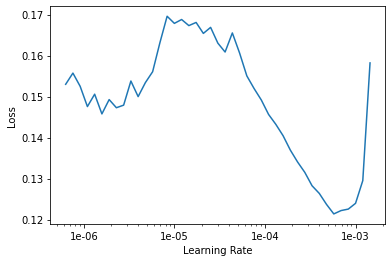

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.179911,0.361602,0.108108,00:07
1,0.140240,0.343129,0.099099,00:07
2,0.130187,0.345748,0.099099,00:07
3,0.108292,0.337521,0.090090,00:07


In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

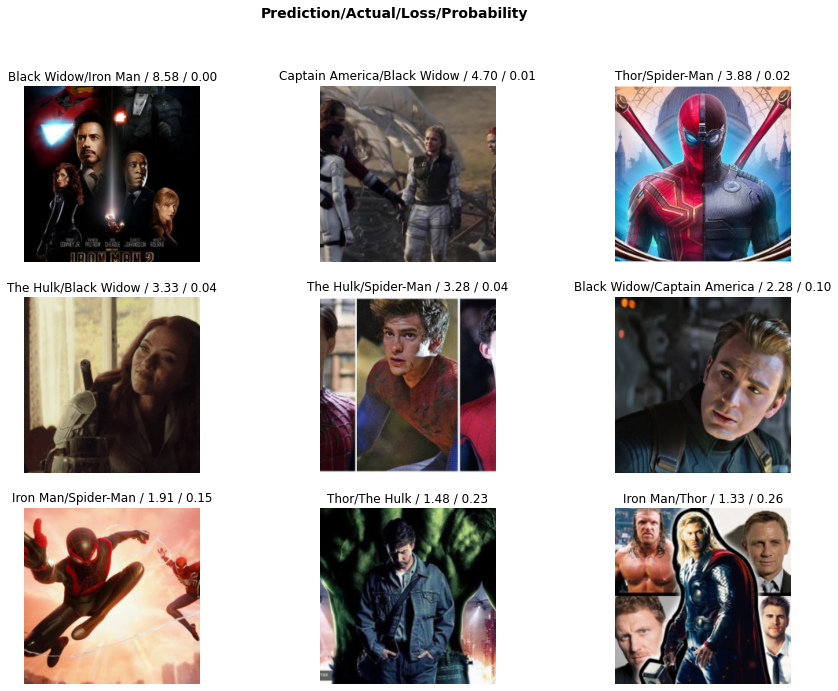

In [ ]:
#@title
interp.plot_top_losses(9, figsize=(15,11))

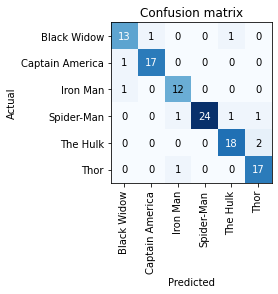

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[('The Hulk', 'Thor', 2),
 ('Black Widow', 'Captain America', 1),
 ('Black Widow', 'The Hulk', 1),
 ('Captain America', 'Black Widow', 1),
 ('Iron Man', 'Black Widow', 1),
 ('Spider-Man', 'Iron Man', 1),
 ('Spider-Man', 'The Hulk', 1),
 ('Spider-Man', 'Thor', 1),
 ('Thor', 'Iron Man', 1)]

In [ ]:
learn.export('marvel-classifier.pkl')

[PosixPath('.config'), PosixPath('images'), PosixPath('sample_data')]